In [261]:
"""Verify the gradient derivation of linear masked autoencoder."""
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import numpy as np
import pandas as pd 
import scipy.stats as stats

In [262]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [263]:
# set default to be float64
torch.set_default_dtype(torch.float64)

### Model initialisation

In [264]:
# Linear auto-encoder model
class LAE(nn.Module):
    def __init__(self, n, p):
        super(LAE, self).__init__()
        self.n = n
        self.p = p
        self.w1 = nn.Linear(n, p, bias=False)
        self.w2 = nn.Linear(p, n, bias=False)

    def forward(self, y):
        y = self.w1(y)
        y = self.w2(y)
        return y

In [265]:
## Masked lienar auto-encoder model
# Define different types of masks
def mask_basic(prob, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob)

def mask_dropping_probs(prob_list: torch.Tensor, sample_num, feature_num):
    return torch.zeros(sample_num, feature_num).bernoulli_(prob_list)

def mask_patches(prob, patch_size: torch.Tensor, sample_num, sample_dim: torch.Tensor):
    feature_num = sample_dim[0]*sample_dim[1]
    div_check = sample_dim % patch_size == torch.zeros(2)
    if torch.all(div_check):
        pix_num = torch.div(sample_dim, patch_size, rounding_mode='floor')
        mat_patches = torch.zeros(sample_num, *pix_num).bernoulli_(prob)
        mat_patches = torch.repeat_interleave(mat_patches, patch_size[1], dim=2)
        return mat_patches.repeat_interleave(patch_size[0], dim=1).view(sample_num, feature_num)
    else:
        raise NotImplementedError(f"Both height ({sample_dim[0]}) and width ({sample_dim[1]}) should be divisible by patch_size ({patch_size}).")


# Masked autoencoder (linear)
class M_LAE(nn.Module):
    def __init__(self, prob, sample_dim, reduction_dim, type='basic', patch_size=None):
        super(M_LAE, self).__init__()
        self.prob = prob
        self.sample_dim = sample_dim
        self.H, self.W = sample_dim
        self.n = self.H * self.W
        self.p = reduction_dim
        if type not in ['basic', 'probs', 'patches']:
            raise NotImplementedError("Could only implement 'basic', 'probs' and 'patches' type of masking.")
        else:
            self.masking_type = type
        if patch_size is not None:
            self.patch_size = patch_size
        w1 = nn.Linear(self.n, self.p, bias=False)
        w2 = nn.Linear(self.p, self.n, bias=False)
        self.body = nn.Sequential(*[w1, w2])
    
    def forward(self, X, mask=None):
        m = X.shape[0]
        if mask is None:
            if self.masking_type == 'basic':
                mask = mask_basic(self.prob, m, self.n).to(device)
            elif self.masking_type == 'probs':
                mask = mask_dropping_probs(self.prob, m, self.n).to(device)
            elif self.masking_type == 'patches':
                mask = mask_patches(self.prob, self.patch_size, m, self.sample_dim).to(device)
        Y = mask * X
        Y = self.body(Y)
        return Y

In [266]:
class FE_Net(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(FE_Net, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.theta = nn.Linear(in_dim, out_dim, bias=False)

    def forward(self, W):
        return self.theta(W)

In [267]:
def train_loop(data_dict, model, criterion, optimizer, type, epochs=10, sample_average=10, record=True):
    train_loss = []
    val_loss = []
    if type=='encoder':
        train_inputs = data_dict['train_inputs']
        train_targets = train_inputs
    elif type=='fe':
        train_inputs = data_dict['train_inputs']
        train_targets = data_dict['train_targets']
        sample_average = 1

    for epoch in range(epochs+1):
        loss_total = 0
        optimizer.zero_grad()
        for i in range(sample_average):
            train_outputs = model(train_inputs)
            loss = criterion(train_outputs, train_targets)
            loss_total += loss
        loss_total /= sample_average
        loss_total.backward()
        optimizer.step()
        if record:
          train_loss.append(loss_total.item())
          if epochs>=5 and epoch%(epochs//5)==0:
              v_loss = test_loop(data_dict, model, criterion, type)
              val_loss.append(v_loss)
              print('epoch: ', epoch, ', train loss: ', loss.item(), ', val loss', v_loss)
    if record:
        return {'train_loss': train_loss, 'val_loss': val_loss}
    else:
        return loss_total.item()

def test_loop(data_dict, model, criterion, type):
    if type=='encoder':
        val_inputs = data_dict['val_inputs']
        val_targets = val_inputs
    elif type=='fe':
        val_inputs = data_dict['val_inputs']
        val_targets = data_dict['val_targets']

    with torch.no_grad():
        val_outputs = model(val_inputs)
        loss = criterion(val_outputs, val_targets)
    return loss.item()

In [268]:
# feature extraction
def feature_extraction(data_dict, model_parameters, criterion, type, epochs=200, device='cuda'):
    train_inputs, train_targets, val_inputs, val_targets = data_dict.values()

    params = list(model_parameters)
    W1 = params[0].clone().detach()
    train_inputs_fe = train_inputs @ W1.T
    val_inputs_fe = val_inputs @ W1.T
    reduction_dim = train_inputs_fe.shape[1]
    target_dim = train_targets.shape[1]

    if type=='ls':
        param_fe = (torch.inverse(train_inputs_fe.T@train_inputs_fe) @ train_inputs_fe.T @ train_targets).T
        loss = criterion(val_targets, val_inputs_fe @ param_fe.T)
        return loss.item()
    elif type=='gd':
        data_dict_fe = {'train_inputs': train_inputs_fe, 'train_targets': train_targets,
                        'val_inputs': val_inputs_fe, 'val_targets': val_targets}
        net_fe = FE_Net(reduction_dim, target_dim).to(device)
        param_fe = list(net_fe.parameters())
        optimizer = optim.Adam(param_fe, lr=0.0001)
        ### TRAINING ###
        loss_fe = train_loop(data_dict_fe, net_fe, criterion, optimizer, epochs=epochs, record=False, type='fe')
        return loss_fe

### Dataset

In [269]:
train_num = 60
val_num = 30
H = 12
W = 12
sample_dim = torch.tensor([H, W])
feature_num = H * W
reduction_dim = 3 * feature_num // 4
target_dim = feature_num // 2

prob = 0.75
prob_list = torch.rand(feature_num)*0.2 + 0.65
patch_size = torch.div(sample_dim, 4, rounding_mode='floor')

train_inputs = torch.rand(train_num, feature_num) * 2
train_inputs = train_inputs.to(device)
train_targets = torch.rand(train_num, target_dim)
train_targets = train_targets.to(device)
val_inputs = torch.rand(val_num, feature_num) * 2
val_inputs = val_inputs.to(device)
val_targets = torch.rand(val_num, target_dim)
val_targets = val_targets.to(device)
data_dict = {'train_inputs': train_inputs, 'train_targets': train_targets,
             'val_inputs': val_inputs, 'val_targets': val_targets}

fe_loss_dict = {'LAE': [], 'MLAE_basic': [], 'MLAE_probs': [], 'MLAE_patches': []}

In [270]:
learning_rate = 0.003
epochs = 500
epochs_fe = 100

### Get features from autoencoder

##### Linear autoencoder

In [271]:
for i in tqdm(range(epochs_fe)):
    net_LAE = LAE(feature_num, reduction_dim).to(device)

    params = list(net_LAE.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_LAE = train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_LAE, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_LAE.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['LAE'].append(loss_gd)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4324610860096467 , val loss 0.954557895161555
epoch:  100 , train loss:  0.06426114691761184 , val loss 0.29353737085306825
epoch:  200 , train loss:  0.013532684193089013 , val loss 0.26373536442636386
epoch:  300 , train loss:  0.003577834997176416 , val loss 0.2550257915764585
epoch:  400 , train loss:  0.0009892725767657491 , val loss 0.2513038027670629
epoch:  500 , train loss:  0.0004892007736073127 , val loss 0.24954414098484298


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


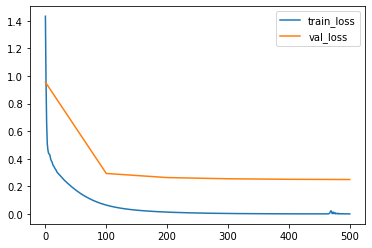

In [272]:
plt.plot(loss_LAE['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_LAE['val_loss'])
plt.legend(loss_LAE.keys())

##### Masked linear autoencoder (basic)

In [273]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_basic = M_LAE(prob, sample_dim, reduction_dim).to(device)

    params = list(net_MLAE_basic.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_basic = train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_basic, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_basic.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_basic'].append(loss_gd)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4682074055583583 , val loss 1.0561868106359908
epoch:  100 , train loss:  0.14994806068134683 , val loss 0.32362916004017406
epoch:  200 , train loss:  0.11921996298986182 , val loss 0.31688022863028575
epoch:  300 , train loss:  0.11247347990579142 , val loss 0.3111281970960357
epoch:  400 , train loss:  0.1059472546748896 , val loss 0.31231487412326353
epoch:  500 , train loss:  0.10768906551738193 , val loss 0.3080394383514419


100%|██████████| 100/100 [04:40<00:00,  2.81s/it]


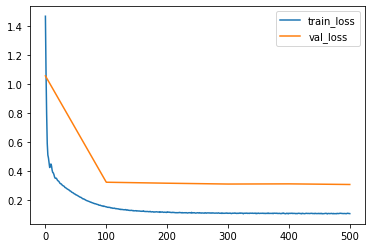

In [274]:
plt.plot(loss_MLAE_basic['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_basic['val_loss'])
plt.legend(loss_MLAE_basic.keys())

##### Masked linear autoencoder (probs)

In [275]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_probs = M_LAE(prob_list, sample_dim, reduction_dim, type='probs').to(device)

    params = list(net_MLAE_probs.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_probs = train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_probs, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_probs.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_probs'].append(loss_gd)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4318262349270854 , val loss 1.0108651618202114
epoch:  100 , train loss:  0.15235604001425535 , val loss 0.3277284291490279
epoch:  200 , train loss:  0.10611620384341026 , val loss 0.31567985317587854
epoch:  300 , train loss:  0.10515045910488512 , val loss 0.3112147776078362
epoch:  400 , train loss:  0.10179088193359061 , val loss 0.3030344825239462
epoch:  500 , train loss:  0.10708635492810274 , val loss 0.3077952014845996


100%|██████████| 100/100 [05:46<00:00,  3.46s/it]


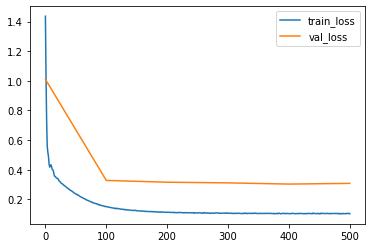

In [276]:
plt.plot(loss_MLAE_probs['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_probs['val_loss'])
plt.legend(loss_MLAE_probs.keys())

##### Masked linear autoencoder (patches)

In [277]:
for i in tqdm(range(epochs_fe)):
    net_MLAE_patches = M_LAE(prob, sample_dim, reduction_dim, type='patches', patch_size=patch_size).to(device)

    params = list(net_MLAE_patches.parameters())
    criterion = nn.MSELoss()
    optimizer = optim.Adam(params, lr=learning_rate)

    ### TRAINING ###
    if i==0:
        loss_MLAE_patches = train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=True, type='encoder')
    else:
        train_loop(data_dict, net_MLAE_patches, criterion, optimizer, epochs=epochs, record=False, type='encoder')

    # feature extraction
    #loss_ls = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='ls', epochs=epochs)
    loss_gd = feature_extraction(data_dict, net_MLAE_patches.parameters(), criterion, type='gd', epochs=epochs)
    fe_loss_dict['MLAE_patches'].append(loss_gd)

  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 , train loss:  1.4406737295013896 , val loss 1.0579124099696404
epoch:  100 , train loss:  0.13613566450629774 , val loss 0.33376725348785985
epoch:  200 , train loss:  0.09744176594059586 , val loss 0.3146325591325198
epoch:  300 , train loss:  0.06906443870362554 , val loss 0.3042677954916104
epoch:  400 , train loss:  0.0637437021669179 , val loss 0.2939104662140702
epoch:  500 , train loss:  0.06260183375396833 , val loss 0.30013442932103646


100%|██████████| 100/100 [06:05<00:00,  3.65s/it]


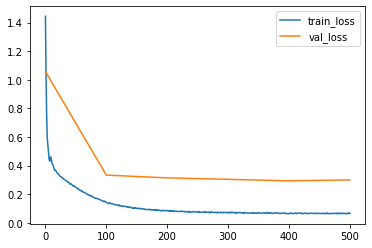

In [278]:
plt.plot(loss_MLAE_patches['train_loss'])
plt.plot(range(0, epochs+1, epochs//5), loss_MLAE_patches['val_loss'])
plt.legend(loss_MLAE_patches.keys())

### Evaluation

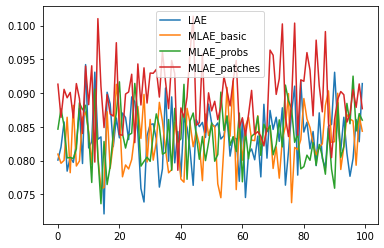

In [279]:
plt.plot(fe_loss_dict['LAE'])
plt.plot(fe_loss_dict['MLAE_basic'])
plt.plot(fe_loss_dict['MLAE_probs'])
plt.plot(fe_loss_dict['MLAE_patches'])
plt.legend(['LAE', 'MLAE_basic', 'MLAE_probs', 'MLAE_patches'])

In [280]:
fe_stats_dict = {'LAE': {'mean': statistics.mean(fe_loss_dict['LAE']), 'sd': statistics.stdev(fe_loss_dict['LAE'])},
                 'MLAE_basic': {'mean': statistics.mean(fe_loss_dict['MLAE_basic']), 'sd': statistics.stdev(fe_loss_dict['MLAE_basic'])},
                 'MLAE_probs': {'mean': statistics.mean(fe_loss_dict['MLAE_probs']), 'sd': statistics.stdev(fe_loss_dict['MLAE_probs'])},
                 'MLAE_patches': {'mean': statistics.mean(fe_loss_dict['MLAE_patches']), 'sd': statistics.stdev(fe_loss_dict['MLAE_patches'])}}
print(fe_stats_dict)

{'LAE': {'mean': 0.08356641758670261, 'sd': 0.004398928671092144}, 'MLAE_basic': {'mean': 0.08311694022988056, 'sd': 0.004106447117429195}, 'MLAE_probs': {'mean': 0.08345179692330086, 'sd': 0.0038732081333735227}, 'MLAE_patches': {'mean': 0.08954864919324565, 'sd': 0.004762176471685005}}


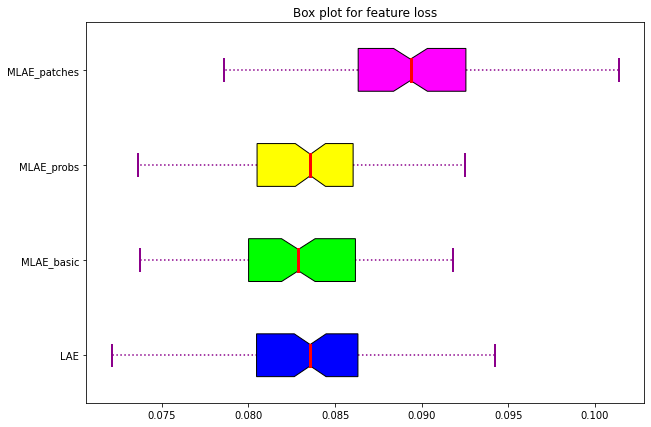

In [281]:
data = fe_loss_dict.values()
 
fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance
bp = ax.boxplot(data, patch_artist = True,
                notch ='True', vert = 0)
 
colors = ['#0000FF', '#00FF00',
          '#FFFF00', '#FF00FF']
 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
 
# changing color and linewidth of
# whiskers
for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")
 
# changing color and linewidth of
# caps
for cap in bp['caps']:
    cap.set(color ='#8B008B',
            linewidth = 2)
 
# changing color and linewidth of
# medians
for median in bp['medians']:
    median.set(color ='red',
               linewidth = 3)
 
# changing style of fliers
for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)
     
# x-axis labels
ax.set_yticklabels(fe_loss_dict.keys())
 
# Adding title
plt.title("Box plot for feature loss")
 
# Removing top axes and right axes
# ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
     
# show plot
plt.show()